In [34]:
from __future__ import division, print_function

import json
import gc
import gzip
import numpy as np
import os
import string
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from glob import iglob
from IPython.display import display, HTML
from operator import itemgetter
from scipy.sparse.linalg import svds
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

In [77]:
def load_descriptions(pickle_file):
    with open(pickle_file, 'rb') as f:
        descriptions = pickle.load(f)
    app_ids, corpus = zip(*descriptions.items())
    print(type(app_ids))
    app_id_to_index = {app_id:app_ids.index(app_id) for app_id in app_ids}
    return app_ids, app_id_to_index, corpus

In [67]:
app_ids, app_id_to_index, corpus = load_descriptions('data/descriptions.pkl')

In [68]:
vectorizer = CountVectorizer(stop_words="english",
                             max_df=.9,
                             min_df=10,
                             ngram_range=(1,2),
                             max_features=6000)

term_doc_matrix = vectorizer.fit_transform(corpus)
print(term_doc_matrix.shape)

(2205, 5525)


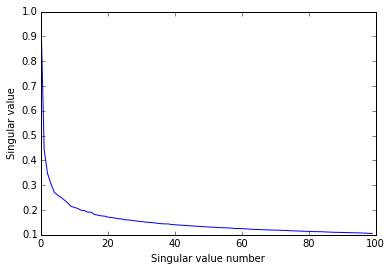

In [69]:
# We can use this graph to check how many dimensions we actually live in
_, s, _ = svds(term_doc_matrix.T.astype(np.float), k=100)
plt.plot(s[::-1]/s.max())
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [39]:
n_topics = 20
model = LDA(n_topics=n_topics, max_iter=10, n_jobs=4, verbose=1)
res = model.fit_transform(term_doc_matrix)
normalized_res = normalize(res)
similarities = normalized_res.dot(normalized_res.T)

/Library/Python/2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [40]:
tsne = TSNE(verbose=1)
projected_docs = tsne.fit_transform(res)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2205
[t-SNE] Computed conditional probabilities for sample 2000 / 2205
[t-SNE] Computed conditional probabilities for sample 2205 / 2205
[t-SNE] Mean sigma: 0.075029
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.228736
[t-SNE] Error after 450 iterations: 1.228736


{u'Indie': 'b', u'Strategy': 'm', u'Adventure': 'r', u'Action': 'g', u'Early Access': 'c', u'Casual': 'y'}


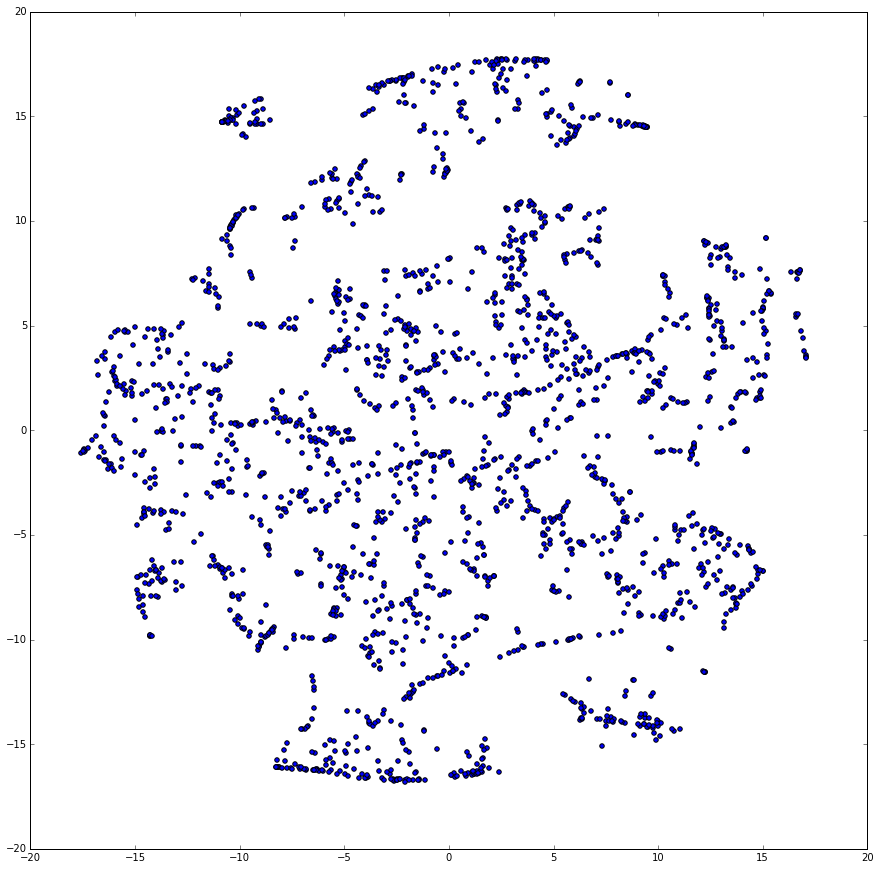

In [57]:
color_index = ["b", "g", "r", "c", "m", "y"]
with open("data/steamspy_games.json") as f:
    games = json.load(f)

best_ranking_tags = defaultdict(int)
for g in games.itervalues():
    if len(g["tags"]) > 0:
        best_ranking_tags[max(g["tags"].iteritems(), key=itemgetter(1))[0]] += 1
tag_names, tag_scores = zip(*best_ranking_tags.iteritems())
tag_names, tag_scores = np.array(tag_names), np.array(tag_scores)
tag_names = tag_names[np.argsort(tag_scores)[:-len(color_index)-1:-1]]
tag_to_color = {name: color for name, color in zip(tag_names, color_index)}
print(tag_to_color)

plt.figure(figsize=(15,15))
plt.scatter(projected_docs[:,0],projected_docs[:,1])
for i, app_id in enumerate(app_ids):
    if app_id in games:
        if len(games[app_id]["tags"]) > 0:
            best_tag = max(games[app_id]["tags"].iteritems(), key=itemgetter(1))[0]
            plt.scatter(projected_docs[i,0], projected_docs[i, 1], color=tag_to_color.get(best_tag, "k"))
plt.show()

In [110]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def print_ranking(similarities, games, app_id, limit=10):
    link = """<a href="http://store.steampowered.com/app/%d">%s</a>"""
    print("Showing ranking for %s (%d)"%(games[str(app_id)]["name"], app_id))
    index = app_id_to_index[app_id]
    ranking = [app_ids[x] for x in np.argsort(similarities[index, :])[::-1]]
    for i in xrange(limit):
        display(HTML(link%(ranking[i], games[str(ranking[i])]["name"])))

def save_compressed_matrix(app_ids, 
                           compressed_matrix,
                           filename="data/compressed_matrix_2.npy"):
    with open(filename, "wb") as f:
        np.save(f, np.column_stack((app_ids, compressed_matrix)))
    
def load_compressed_matrix(filename="data/compressed_matrix_2.npy"):
    with open(filename, "rb") as f:
        arr = np.load(f)
    return arr[:, 0].astype(np.int), arr[:, 1:]

In [111]:
print_top_words(model, vectorizer.get_feature_names(), 10)

Topic #0:
sam mental egypt stone embrace frantic stop action non stop 16 players redesigned
Topic #1:
world island power ancient enemies land fight survive attacks way
Topic #2:
duty players zombies multiplayer modes zombie maps team toy game
Topic #3:
fusion bending mind bending cameras summer mind proper security example game
Topic #4:
city racing race car cars new vehicles tracks track world
Topic #5:
game story world new adventure characters features original explore unique
Topic #6:
guy took ordinary station prison brutal security originally released brothers shift
Topic #7:
new combat experience world battle action weapons player enemies mode
Topic #8:
middle lord ring rings earth north satisfying halls reclaim op action
Topic #9:
ship space ships galaxy crew pirate trade universe fleet nation
Topic #10:
war new battle strategy battles units campaign empire players ii
Topic #11:
weapons players combat enemies play planet alien team unique mode
Topic #12:
stress directx tests benc

In [115]:
subnautica = 264710
dark_souls = 211420
golf_with_your_friends = 431240
dota_2 = 570

In [116]:
print_ranking(similarities, games, subnautica)
print_ranking(similarities, games, dark_souls)
print_ranking(similarities, games, golf_with_your_friends)
print_ranking(similarities, games, dota_2)

Showing ranking for Subnautica (264710)


Showing ranking for DARK SOULS™: Prepare To Die™ Edition (211420)


Showing ranking for Golf With Your Friends (431240)


Showing ranking for Dota 2 (570)


In [74]:
save_compressed_matrix(app_ids, normalized_res)

In [76]:
loaded_app_ids, loaded_matrix = load_compressed_matrix()